In [241]:
import numpy as np
import pickle
import pandas as pd
#import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Activation, Dense, Input, Reshape, Flatten,TimeDistributed
from keras.layers import LSTM, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers import ConvLSTM2D

from tqdm import tqdm
import time

from helper_functions import *


In [242]:
DATA_FOLDER = "../data/"

In [243]:
import os
os.listdir(DATA_FOLDER)

['data_base_test.pkl',
 '.DS_Store',
 'data_base_train.pkl',
 'data_indicators_base_train.pkl',
 'quantiacs_futures_details.csv',
 'data_indicators_base_test.pkl',
 'Data Library.ipynb',
 'data_indicators_stack_test.pkl',
 'data_stack_test.pkl']

latest is USA_RFMI 1993-12-01 00:00:00

In [244]:
def read_from_pkl(PATH):
    data = pickle.load(open(DATA_FOLDER + PATH, "rb" ), encoding='latin1')
    return data
    

In [245]:
def preprocess_train(price_data, indicator):
    price_data = price_data.loc[price_data.index >= '1994-01-01']
    start_index = price_data['CLOSE'].first_valid_index()
    price_data = price_data.loc[price_data.index >= start_index]
    print("price data start from: ", start_index)
    print("merge with indicators ...")
    train = price_data.join(indicator, on='DATE')
    print("fill NAs ...")
    train = train.fillna(method="bfill").reset_index()
    train.rename(columns = {'DATE':'ds','CLOSE':'y'},inplace=True)
    print("Done")
    return train

In [246]:
def preprocess_test(price_data, indicator):
    #price_data = price_data.loc[price_data.index >= '1994-01-01']
    #start_index = price_data['CLOSE'].first_valid_index()
    #price_data = price_data.loc[price_data.index >= start_index]
    #print("price data start from: ", start_index)
    print("merge with indicators ...")
    test = price_data.join(indicator, on='DATE')
    print("fill NAs ...")
    test = test.fillna(method="bfill").reset_index()
    test.rename(columns = {'DATE':'ds','CLOSE':'y'},inplace=True)
    print("Done")
    return test

### Read data 

In [247]:
train = read_from_pkl("data_base_train.pkl" ) 
test = read_from_pkl("data_base_test.pkl" ) 
train_idc = read_from_pkl("data_indicators_base_train.pkl") 
test_idc = read_from_pkl("data_indicators_base_test.pkl") 

preprocess 

In [248]:
fad_train = preprocess_train(train['F_AD'], train_idc)
fad_test = preprocess_test(test['F_AD'], test_idc)

price data start from:  1994-01-03 00:00:00
merge with indicators ...
fill NAs ...
Done
merge with indicators ...
fill NAs ...
Done


In [254]:
from fbprophet import Prophet

def run_prophet(train, test):
    model = Prophet()  
    
    model.add_country_holidays(country_name='US')
    
    # concate data with extra regressors 
    # train_idc = train_idc.reset_index(drop=True)
    # train = pd.concat([train,train_idc], axis=1)
    # print(train.head())
    
    for each in list(train_idc.columns):
        if each == "ds":
            pass
        if each == "y":
            pass
        model.add_regressor(each)
        
    # fit model
    model.fit(train)
    
    # predict
    forecast = model.predict(test)
    y_pred = forecast['yhat']
    
    true_pred = pd.DataFrame({'y_true':test['y'], 
                              'y_pred': y_pred})
    true_pred.dropna()
    
    rmse = rmse_ratio(true_pred['y_pred'], true_pred['y_true'])
    mape = mean_absolute_percentage_error(true_pred['y_pred'], true_pred['y_true'])
    
    print("rmse:", rmse)
    print("mape:", mape)
    #print(y_pred, test['y'])
    
    return forecast, true_pred

In [255]:
fad_test.columns

Index(['ds', 'OPEN', 'HIGH', 'LOW', 'y', 'USA_BC', 'USA_BI', 'USA_BOT',
       'USA_CCPI', 'USA_CCR', 'USA_CF', 'USA_CFNAI', 'USA_CINF', 'USA_CP',
       'USA_CPI', 'USA_CPIC', 'USA_CPICM', 'USA_CU', 'USA_DUR', 'USA_DURET',
       'USA_EXPX', 'USA_EXVOL', 'USA_FBI', 'USA_FRET', 'USA_GBVL', 'USA_GPAY',
       'USA_HI', 'USA_IMPX', 'USA_IMVOL', 'USA_IP', 'USA_IPMOM', 'USA_LEI',
       'USA_LFPR', 'USA_MP', 'USA_MPAY', 'USA_NAHB', 'USA_NFIB', 'USA_NFP',
       'USA_NLTTF', 'USA_NPP', 'USA_PFED', 'USA_PPIC', 'USA_RFMI', 'USA_RSEA',
       'USA_RSM', 'USA_RSY', 'USA_TVS', 'USA_UNR', 'USA_WINV'],
      dtype='object')

In [256]:
forecast, result = run_prophet(fad_train, fad_test)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


rmse: 50.808251543778866
mape: 18.80890341449131


In [141]:
result.head(10)

,y_true,y_pred
0,NaN,78847.010121
1,71580.0,78964.448405
2,71270.0,79028.291220
3,70370.0,79078.856022
4,69730.0,79159.083189
5,69630.0,79181.128901
6,69610.0,79216.235049
7,69640.0,79241.611735
8,69390.0,79249.393915
9,69770.0,79283.397082


In [5]:
train1 = train['F_AD','CLOSE'].reset_index()
train1.columns = ['Date','CLOSE']
train1['Date'] = pd.to_datetime(train1['Date'],format='%Y-%m-%d')

In [6]:
train1.columns=['ds','y']

#### Prophet Model

In [7]:
from fbprophet import Prophet
model = Prophet(holidays=holidays) # add holidays
model.add_country_holidays(country_name='US')

model.fit(train1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
test1 = test['F_AD','CLOSE'].reset_index()
test1.columns = ['Date','CLOSE']
#test1['Date'] = pd.to_datetime(test['Date'],format='%Y-%m-%d')
test1.columns=['ds','y']

In [13]:
forecast = model.predict(test1[['ds']])

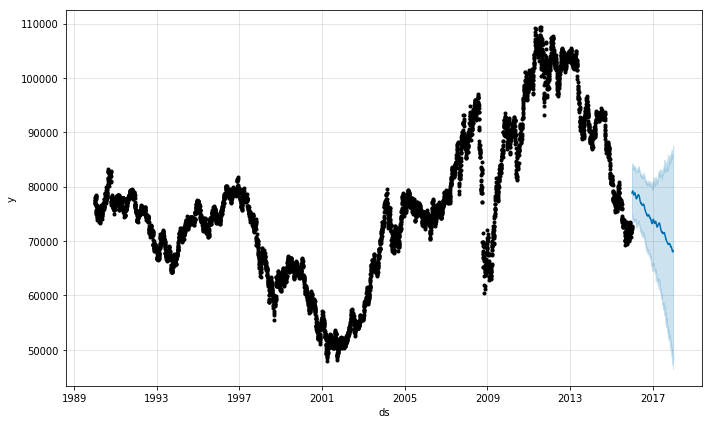

In [35]:
fig1 = model.plot(forecast)

In [ ]:
test1[['ds']]

In [38]:
26819535.511931125 ** 0.5

5178.758105176484